# Imports

In [1]:
import re
import numpy as np
import pandas as pd
#For Tables:
from IPython.display import display
pd.set_option('display.max_columns', 500)

from pprint import pprint
from datetime import datetime
import os, sys

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# unidecode
import unidecode as UN

#SQLalchemy for database
from sqlalchemy import create_engine

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.corpus import names
from stop_words import get_stop_words

# add any wanted stopwords here
name_list = names.words('male.txt') + names.words('female.txt')
name_list = [UN.unidecode(name.lower()) for name in name_list]
en_stop = get_stop_words('en') + get_stop_words('fr') + name_list + ['volume', 'issue', 'magazine', 'article', 'doi', 'preprint',
                                                                    'introduction', 'background', 'result', 'results','conclusion', 'conclusions',
                                                                    'limitations', 'acknowledgements','biorxiv', 'peer', 'review', 'fig',
                                                                    'figure', 'image', 'copyright', 'publication', 'author', 'authors', 'publish', 'editor'] 

stop_words.extend(en_stop)

# Reads data

In [2]:
## TBIncluded in a config file
engine = create_engine('sqlite:///DB/papers_DB_COVID-19.db')
mallet_path = os.getcwd() + '/Mallet/mallet-2.0.8/bin/mallet'

### Gets parameters for the DB
print('Reading file')
query = "SELECT * FROM Complete;" 
# Reads the data
dataFrame_cpl = pd.read_sql(query, engine).dropna(subset=['Full text'])

#This part might have to change
dataFrame_cpl = dataFrame_cpl.drop(columns=['level_0','index']).reset_index().drop(columns=['index'])

Reading file


In [3]:
#Adding medrxiv & bioarxiv items that were not added to the "complete" table  => NEEDS TO BE CHANGED
dataFrameMED = pd.read_sql("SELECT * FROM medXiv;", engine).dropna(subset=['Full text'])
dataFrameBIO = pd.read_sql("SELECT * FROM biorXiv;", engine).dropna(subset=['Full text'])

dataFrame_ppt = pd.concat([dataFrameMED,dataFrameBIO])
#dataFrame_ppt
dataFrame = pd.concat([dataFrame_cpl,dataFrame_ppt])

/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """
/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [4]:
dataFrame = dataFrame[['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'arXID','RxivistID', 'Authors', 'Abstract', 'Full text', 'URL']]
dataFrame.columns = ['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'arXID', 'RxivistID', 'Authors', 'Abstract', 'Full_text', 'URL']
dataFrame.head()

# dataFrame = dataFrame[['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'PaperityID', 'arXID', 'Authors', 'Abstract', 'Full text', 'URL']]
# dataFrame.columns = ['Title', 'Date', 'DOI', 'PMCID', 'PMID', 'PaperityID', 'arXID', 'Authors', 'Abstract', 'Full_text', 'URL']

Title     Date   DOI    PMCID  \
0  a novel coronavirus outbreak from wuhan city i...  2020-02  None  7075272   
1  coronavirus pandemic and worries during pregna...  2020-03  None  7075675   
2  information typology in coronavirus (covid-19)...  2020-03  None  7075270   
3  liver and kidney injuries in covid-19 and thei...  2020-03  None  7075271   
4  modeling the control of covid-19: impact of po...  2020-03  None     None   

       PMID       arXID RxivistID  \
0  32185368        None       NaN   
1  32185371        None       NaN   
2  32185370        None       NaN   
3  32185369        None       NaN   
4      None  2003.02985       NaN   

                                             Authors  \
0                            Alavi-Moghaddam Mostafa   
1            Rashidi Fakari Farzaneh;Simbar Masoumeh   
2                 Ashrafi-rizi Hasan;Kazempour Zahra   
3                           Rismanbaf Ali;Zarei Sara   
4  Jia Jiwei;Ding Jian;Liu Siyu;Liao Guidong;Li J...   

                                            Abstract  \
0                                               None   
1                                               None   
2                                               None   
3                                               None   
4  In this paper, we propose a dynamical model to...   

                                           Full_text  \
0  Dear Editor On 31 December 2019, Chinese autho...   
1  Dear editor: Coronavirus (COVID-19) is a new r...   
2  Introduction: In late 2019 and early 2020, man...   
3  Dear Editor, COVID-19 is a newly emerging huma...   
4   ARTICLES   doi  arXivv q-bioPE  Mar   Modelin...   

                                   URL  
0                                 None  
1                                 None  
2                                 None  
3                                 None  
4  http://arxiv.org/pdf/2003.02985.pdf

# Cleans some stuff

In [5]:
# Convert to list
data = dataFrame.Full_text.values.tolist()
# Test with first 1000 => Make sure you change the number also in format_topics_sentences
# data = data[:1000]
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]
# Remove http remnants in the text
data = [re.sub(r'^http?.*[\r\n]*', '', sent) for sent in data]
# Remove www remnants in the text
data = [re.sub(r'^www?.*[\r\n]*', '', sent) for sent in data]


#Gensim possess an optimised preprocessing tool that can remove punctuation as well
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [6]:
len(data)

1666

# Build the bigram and trigram models

In [7]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
# print(trigram_mod[bigram_mod[data_words[0]]])

# Define functions for stopwords, bigrams, trigrams and lemmatization

In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Applies the aforementionned functions

In [9]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)

# Create dictionnary and corpus

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Human readable format of corpus (term-frequency)
# [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Tries to find the best value for number of topics with LDA Mallet (better results than classical LDA)

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
# Runs the test for up to 100 topics starting from 10 topics, with incrementing topic number by 10 each time. That's too much steps for large corpus
limit=100
start=5
step=5

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start, limit=limit, step=step)

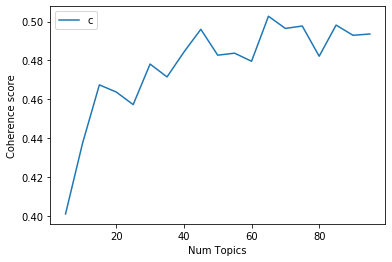

Num Topics = 5  has Coherence Value of 0.401
Num Topics = 10  has Coherence Value of 0.4372
Num Topics = 15  has Coherence Value of 0.4674
Num Topics = 20  has Coherence Value of 0.4637
Num Topics = 25  has Coherence Value of 0.4573
Num Topics = 30  has Coherence Value of 0.4781
Num Topics = 35  has Coherence Value of 0.4715
Num Topics = 40  has Coherence Value of 0.4843
Num Topics = 45  has Coherence Value of 0.496
Num Topics = 50  has Coherence Value of 0.4827
Num Topics = 55  has Coherence Value of 0.4837
Num Topics = 60  has Coherence Value of 0.4796
Num Topics = 65  has Coherence Value of 0.5027
Num Topics = 70  has Coherence Value of 0.4964
Num Topics = 75  has Coherence Value of 0.4977
Num Topics = 80  has Coherence Value of 0.4821
Num Topics = 85  has Coherence Value of 0.4982
Num Topics = 90  has Coherence Value of 0.4929
Num Topics = 95  has Coherence Value of 0.4936


In [13]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

#The best value is for when the curve starts to flatten and not increase much anymore

# Use best model

In [14]:
# Select the model and print the topics
optimal_model = model_list[14]  #=> here change for the most accurate model
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(38,
  '0.017*"microscopy" + 0.012*"single" + 0.012*"intensity" + 0.011*"molecule" '
  '+ 0.011*"fluorescence" + 0.010*"supplementary" + 0.009*"localization" + '
  '0.009*"high" + 0.009*"imaging" + 0.009*"sample"'),
 (35,
  '0.054*"network" + 0.049*"state" + 0.014*"function" + 0.013*"set" + '
  '0.012*"point" + 0.011*"high" + 0.011*"space" + 0.011*"dynamic" + '
  '0.010*"edge" + 0.010*"datum"'),
 (30,
  '0.239*"make" + 0.156*"license" + 0.131*"international" + 0.017*"datum" + '
  '0.015*"cc" + 0.014*"table" + 0.011*"study" + 0.010*"present" + '
  '0.010*"number" + 0.009*"show"'),
 (18,
  '0.041*"enrichment" + 0.028*"analysis" + 0.027*"pathway" + 0.023*"set" + '
  '0.022*"expression" + 0.017*"enrich" + 0.013*"annotation" + 0.011*"network" '
  '+ 0.011*"regulation" + 0.011*"term"'),
 (45,
  '0.043*"human" + 0.034*"cortical" + 0.025*"brain" + 0.022*"area" + '
  '0.014*"region" + 0.013*"frequency" + 0.009*"surface" + 0.009*"oscillation" '
  '+ 0.008*"gradient" + 0.008*"connection"'),
 (16

# Visualizes LDA

In [15]:
pyLDAvis.enable_notebook()
# Careful when looking with pyLDA! the built-im conversion to mallet to classical LDA harbours bugs (see https://github.com/RaRe-Technologies/gensim/issues/2069)
#lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Working alternative, but the topic number on the vis is not the one as obtained on the previous cell
def mallet_to_lda(mallet_model):
    model_gensim = gensim.models.ldamodel.LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0, iterations=1000,
        gamma_threshold=0.001,
        dtype=np.float32
    )
    model_gensim.sync_state()
    model_gensim.state.sstats = mallet_model.wordtopics
    return model_gensim

vis = pyLDAvis.gensim.prepare(mallet_to_lda(optimal_model), corpus, id2word)
pyLDAvis.save_html(vis, os.getcwd() + "/Mallet/result_vis.html")
vis


/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/mnt/c/Users/thiabaud/Documents/Environments/ASR/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  r

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.167937  0.007616       1        1  8.016106
41    -0.051095  0.151556       2        1  5.727036
70    -0.028710  0.074112       3        1  5.314338
61    -0.154080 -0.044062       4        1  5.013682
62     0.069749  0.026206       5        1  3.749260
...         ...       ...     ...      ...       ...
8      0.045952  0.112415      71        1  0.233020
24    -0.200055 -0.028161      72        1  0.232152
48    -0.100034 -0.005110      73        1  0.222683
64    -0.020254 -0.120154      74        1  0.203598
28     0.133400  0.014778      75        1  0.189467

[75 rows x 5 columns], topic_info=     Category          Freq        Term         Total  loglift  logprob
1552  Default  44652.000000        cell  44652.000000  30.0000  30.0000
1015  Default  38566.000000  population  38566.000000  29.0000  29.0000
1420  Default  19156.000000     protein  19156.000000  28.0000  28.0000
251   Default  35931.000000    sequence  35931.000000  27.0000  27.0000
1642  Default  38235.000000  expression  38235.000000  26.0000  26.0000
...       ...           ...         ...           ...      ...      ...
733   Topic75     47.797479      animal   4791.415319   1.6611  -5.4164
265   Topic75     51.689782    specific  13602.900928   0.6959  -5.3381
909   Topic75     45.462097      immune   6408.311352   1.3202  -5.4665
1763  Topic75     44.527945     observe  10929.363218   0.7656  -5.4873
533   Topic75     42.659639       level  16173.915101   0.3308  -5.5302

[8076 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
31435     11  0.998391          aaeggr
31444     11  0.998938           aaegl
44541     49  1.571232          aafter
35015     40  1.007459           aagag
53146     50  1.944563  aagreeableness
...      ...       ...             ...
9197      12  0.997825        zinc_ion
34657     67  1.483796            zink
2169      25  0.908755        zoonotic
2169      75  0.094945        zoonotic
22317     63  1.067223   zymo_research

[28895 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 42, 71, 62, 63, 67, 69, 52, 18, 30, 26, 45, 58, 40, 27, 38, 73, 33, 23, 21, 20, 2, 19, 5, 61, 60, 70, 39, 47, 16, 6, 55, 17, 31, 7, 75, 4, 56, 41, 22, 28, 12, 72, 1, 37, 10, 46, 54, 14, 59, 51, 13, 57, 35, 3, 8, 48, 53, 74, 32, 66, 43, 68, 15, 24, 64, 50, 34, 44, 36, 9, 25, 49, 65, 29])

# Builds and evaluates one LDA model (to do for a test)

In [16]:
# # Build LDA model with Mallet, which usually provides better results
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# #View the topics
# pprint(ldamallet.show_topics(formatted=False))

# # Compute Perplexity
# print('\nPerplexity: ', ldamallet.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

In [17]:
# # Here for the classical model
# # chunksize is the number of entries to use at each training; update_every updates the parameters every pass, passes is the max number of passes to go for training
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)


# #View the topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

# # Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)

# Allocate the dominant topic to each document

In [18]:
def format_topics_sentences(ldamodel, original_data, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    # ldamodel[corpus] contains a list of tupples with (topic_nb, score_of_doc_for_topic) for each documents
    for i, row in enumerate(ldamodel[corpus]):
        # Sorts the score from highest to lowest
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                # wp contains a list of tuples with (word, score_of_word_for_topic)
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = "; ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output => possible because the document index hasn't changed from data to data_lemmatized
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    #Careful this will only work if the subset testing start from beginning to somewhere uninterrupted or full dataset
    for column in original_data.columns:
        contents_col = original_data[column].values.tolist()
        # contents_col = contents_col[:1000] #Here to change depensing on size of subset
        contents_col = pd.Series(contents_col)
        sent_topics_df = pd.concat([sent_topics_df, contents_col], axis=1)
        
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, original_data=dataFrame, corpus=corpus, texts=data)

In [19]:
# Format => Columns name might have to change
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_Number', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text',
                             'Title', 'Date', 'DOI', 'PMCID', 'PMID', 'arXID', 'RxivistID', 'Authors', 'Abstract', 'Full_text', 'URL']

In [20]:
# Show
df_dominant_topic.tail(10)

Document_Number  Dominant_Topic  Topic_Perc_Contrib  \
1656             1656             3.0              0.3710   
1657             1657            33.0              0.5957   
1658             1658            62.0              0.4059   
1659             1659            21.0              0.3021   
1660             1660            71.0              0.4355   
1661             1661             6.0              0.5227   
1662             1662            43.0              0.3133   
1663             1663            22.0              0.5231   
1664             1664            70.0              0.6442   
1665             1665            59.0              0.4754   

                                               Keywords  \
1656  model; estimate; datum; sample; predict; facto...   
1657  trial; activity; neuron; neural; response; pop...   
1658  muscle; reuse_allowe; bone; limb; body; latera...   
1659  chromosome; genomic; genome; centromere; strai...   
1660  cell; peak; expression; differentiation; singl...   
1661  variant; genetic; effect; trait; snps; analysi...   
1662  plant; root; arabidopsis; response; signal; sh...   
1663  male; female; sex; individual; difference; pre...   
1664  selection; population; mutation; fitness; gene...   
1665  neuron; mouse; signal; fluorescence; light; re...   

                                                   Text  \
1656  bioRxiv preprint doi httpsdoiorg The copyright...   
1657  bioRxiv preprint doi httpsdoiorg The copyright...   
1658  bioRxiv preprint doi httpsdoiorg The copyright...   
1659  bioRxiv preprint doi httpsdoiorg The copyright...   
1660  bioRxiv preprint doi httpsdoiorg The copyright...   
1661  bioRxiv preprint doi httpsdoiorg The copyright...   
1662  bioRxiv preprint doi httpsdoiorg The copyright...   
1663  bioRxiv preprint doi httpsdoiorg The copyright...   
1664  bioRxiv preprint doi httpsdoiorg The copyright...   
1665  bioRxiv preprint doi httpsdoiorg The copyright...   

                                                  Title        Date  \
1656  Measuring and Mitigating PCR Bias in Microbiom...  2019-04-09   
1657  Independent population coding of the present a...  2019-06-12   
1658  Latent developmental potential to form limb-li...  2018-10-23   
1659  Altered chromatin localization of hybrid letha...  2018-10-08   
1660  Building gene regulatory networks from single-...  2018-10-09   
1661  Theoretical and empirical quantification of th...  2020-01-15   
1662  An ancient integration in a plant NLR is maint...  2017-12-25   
1663  Hormonal and neural correlates of care in acti...  2019-09-11   
1664  Polygenic Adaptation: From sweeps to subtle fr...  2018-10-23   
1665  Stability, affinity and chromatic variants of ...  2017-12-15   

                            DOI PMCID PMID arXID RxivistID  \
1656             10.1101/604025   NaN  NaN   NaN     48147   
1657             10.1101/668962   NaN  NaN   NaN     53154   
1658             10.1101/450619   NaN  NaN   NaN     35570   
1659             10.1101/438432   NaN  NaN   NaN     34317   
1660             10.1101/438937   NaN  NaN   NaN     34240   
1661  10.1101/2020.01.14.905927   NaN  NaN   NaN     71106   
1662             10.1101/239541   NaN  NaN   NaN     28076   
1663             10.1101/765503   NaN  NaN   NaN     60512   
1664             10.1101/450759   NaN  NaN   NaN     35539   
1665             10.1101/235176   NaN  NaN   NaN     14123   

                                                Authors  \
1656  Justin D Silverman;Rachael J Bloom;Sharon Jian...   
1657                     Silvia Maggi;Mark D. Humphries   
1658    M. Brent Hawkins;Katrin Henke;Matthew P. Harris   
1659  J.C. Cooper;A. Lukacs;S. Reich;T. Schauer;A. I...   
1660  Camden Jansen;Ricardo N. Ramirez;Nicole C. El-...   
1661  Ying Wang;Jing Guo;Guiyan Ni;Jian Yang;Peter M...   
1662  Helen J Brabham;Inmaculada Hernández-Pinzón;Sa...   
1663                 Eva K. Fischer;Lauren A. O’Connell   
1664  Ilse Höllinger;Pleuni S. Penning

# Allocate the dominant document for each topic

In [21]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [22]:
# Format => Column names might have to change
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text",
                                       'Title', 'Date', 'DOI', 'PMCID', 'PMID', 'arXID', 'RxivistID', 'Authors', 'Abstract', 'Full_text', 'URL']

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
724         0.0              0.5941   
1606        1.0              0.7823   
1499        2.0              0.7109   
627         3.0              0.5689   
697         4.0              0.6367   
...         ...                 ...   
1133       70.0              0.6456   
1442       71.0              0.5765   
1297       72.0              0.7194   
1249       73.0              0.7185   
1094       74.0              0.4520   

                                               Keywords  \
724   tree; branch; specie; method; sequence; alignm...   
1606  system; drive; design; record; device; control...   
1499  bind; site; interaction; ctcf; motif; region; ...   
627   model; estimate; datum; sample; predict; facto...   
697   cell; tissue; show; flow; time; migration; mov...   
...                                                 ...   
1133  selection; population; mutation; fitness; gene...   
1442  cell; peak; expression; differentiation; singl...   
1297  particle; resolution; structure; cryo; density...   
1249  population; individual; ancestry; genetic; sam...   
1094  model; simulation; probability; rate; paramete...   

                                                   Text  \
724   bioRxiv preprint doi httpsdoiorg The copyright...   
1606  bioRxiv preprint doi httpsdoiorg The copyright...   
1499  bioRxiv preprint doi httpsdoiorg The copyright...   
627   bioRxiv preprint doi httpsdoiorg The copyright...   
697   bioRxiv preprint doi httpsdoiorg The copyright...   
...                                                 ...   
1133  bioRxiv preprint doi httpsdoiorg The copyright...   
1442  bioRxiv preprint doi httpsdoiorg The copyright...   
1297  bioRxiv preprint doi httpsdoiorg The copyright...   
1249  bioRxiv preprint doi httpsdoiorg The copyright...   
1094  bioRxiv preprint doi httpsdoiorg The copyright...   

                                                  Title        Date  \
724   OrthoFinder: phylogenetic orthology inference ...  2018-11-08   
1606  An easy-to-assemble, robust, and lightweight d...  2019-08-24   
1499  CTCF-dependent chromatin boundaries formed by ...  2019-04-25   
627   Consistent and correctable bias in metagenomic...  2019-02-25   
697   Parallel control of mechanosensory hair cell o...  2019-01-23   
...                                                 ...         ...   
1133  The Linked Selection Signature of Rapid Adapta...  2019-02-24   
1442  Single-cell epigenomics maps the continuous re...  2017-02-21   
1297  High-resolution structure determination of sub...  2018-12-07   
1249  Fine-scale genomic analyses of admixed individ...  2020-01-24   
1094  Phylogenies of extant species are consistent w...  2019-07-31   

                            DOI PMCID PMID arXID RxivistID  \
724              10.1101/466201   NaN  NaN   NaN     36415   
1606             10.1101/746651   NaN  NaN   NaN     59012   
1499             10.1101/618827   NaN  NaN   NaN     49263   
627              10.1101/559831   NaN  NaN   NaN     44717   
697              10.1101/527937   NaN  NaN   NaN     42231   
...                         ...   ...  ...   ...       ...   
1133             10.1101/559419   NaN  NaN   NaN     44659   
1442             10.1101/109843   NaN  NaN   NaN      7935   
1297             10.1101/489898   NaN  NaN   NaN     38125   
1249  10.1101/2020.01.24.917898   NaN  NaN   NaN     71905   
1094             10.1101/719435   NaN  NaN   NaN     57131   

                                                Authors  \
724                              D.M. Emms;Steven Kelly   
1606  Jakob Voigts;Jonathan P. Newman;Matthew A Wils...   
1499  Christopher T. Clarkson;Emma A Deeks;Ralph Sam...   
627   Michael R. McLaren;Amy D. Willis;Benjamin J. C...   
697   Joaquin Navajas Acedo;Matthew G Voas;Richard A...   
...                                                 ...   
1133                          Vince Buffalo;Graham Coop   
1442  Jason D. Buenrostro;M. Ryan Corces;Beijing 

# Topic distribution and how many docs are allocated to one topic

In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']].reset_index().drop(columns=['index'])
# Concatenate Column wise
df_distr = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
# Change Column names
df_distr.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_distr

Dominant_Topic                                     Topic_Keywords  \
0.0              0.0  tree; branch; specie; method; sequence; alignm...   
1.0              1.0  system; drive; design; record; device; control...   
2.0              2.0  bind; site; interaction; ctcf; motif; region; ...   
3.0              3.0  model; estimate; datum; sample; predict; facto...   
4.0              4.0  cell; tissue; show; flow; time; migration; mov...   
...              ...                                                ...   
70.0            70.0  selection; population; mutation; fitness; gene...   
71.0            71.0  cell; peak; expression; differentiation; singl...   
72.0            72.0  particle; resolution; structure; cryo; density...   
73.0            73.0  population; individual; ancestry; genetic; sam...   
74.0            74.0  model; simulation; probability; rate; paramete...   

      Num_Documents  Perc_Documents  
0.0              16          0.0096  
1.0              15          0.0090  
2.0              28          0.0168  
3.0               8          0.0048  
4.0              24          0.0144  
...             ...             ...  
70.0             14          0.0084  
71.0             22          0.0132  
72.0             16          0.0096  
73.0             26          0.0156  
74.0              5          0.0030  

[75 rows x 4 columns]

In [24]:
# Show
for i, item in enumerate(df_distr['Topic_Keywords'].tolist()):
    print(i,item)

0 tree; branch; specie; method; sequence; alignment; phylogenetic; support; phylogeny; derive
1 system; drive; design; record; device; control; electrode; mask; pressure; recording
2 bind; site; interaction; ctcf; motif; region; chromatin; contact; peak; chromosome
3 model; estimate; datum; sample; predict; factor; variable; correlation; error; effect
4 cell; tissue; show; flow; time; migration; movie; embryo; dynamic; hair
5 brain; task; functional; subject; measure; study; neuroimage; analysis; correlation; region
6 variant; genetic; effect; trait; snps; analysis; individual; study; estimate; supplementary
7 patient; study; clinical; disease; display; risk; license; perpetuity; reuse_allowe; severe
8 participant; trial; response; level; decision; subject; face; category; visual; stimulus
9 insertion; methylation; sequence; element; region; genome; site; identify; copy; family
10 population; allele; sample; human; genome; haplotype; region; estimate; sequence; site
11 embryo; maternal

# Save documents for each topic

In [25]:
total = 0
for j in df_dominant_topic.Dominant_Topic.unique():
    data_save = pd.DataFrame()
    data_save = df_dominant_topic.copy()
    data_save = data_save[data_save.Dominant_Topic == j]
    data_save = data_save[['Document_Number', 'Dominant_Topic', 'Keywords','Title', 'Date', 'DOI', 'URL']]
    if not pd.isnull(j):
        data_save.to_csv('Mallet/Results_topic_' + (str(int(j))) + '.csv')
    else:
        data_save.to_csv('Mallet/Unallocated.csv')
    total += data_save.shape[0]

# Checks that the total encompass the same amount as the original data

In [26]:
total

1666

In [27]:
len(data)

1666